In [3]:
#pip install tensorflow

In [4]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


data = pd.read_csv('data_no_bg.csv')

# Paramètres du modèle

input_shape = (256, 256, 3)  
num_classes = len(data.nom_maladie.unique())

data.loc[data['malade'] == False, 'nom_maladie'] = 'healthy'

data.head()

,img_path,espece,malade,nom_maladie
0,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab
1,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab
2,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab
3,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab
4,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab


### Division du jeu de données en 10 dataframes équilibrés

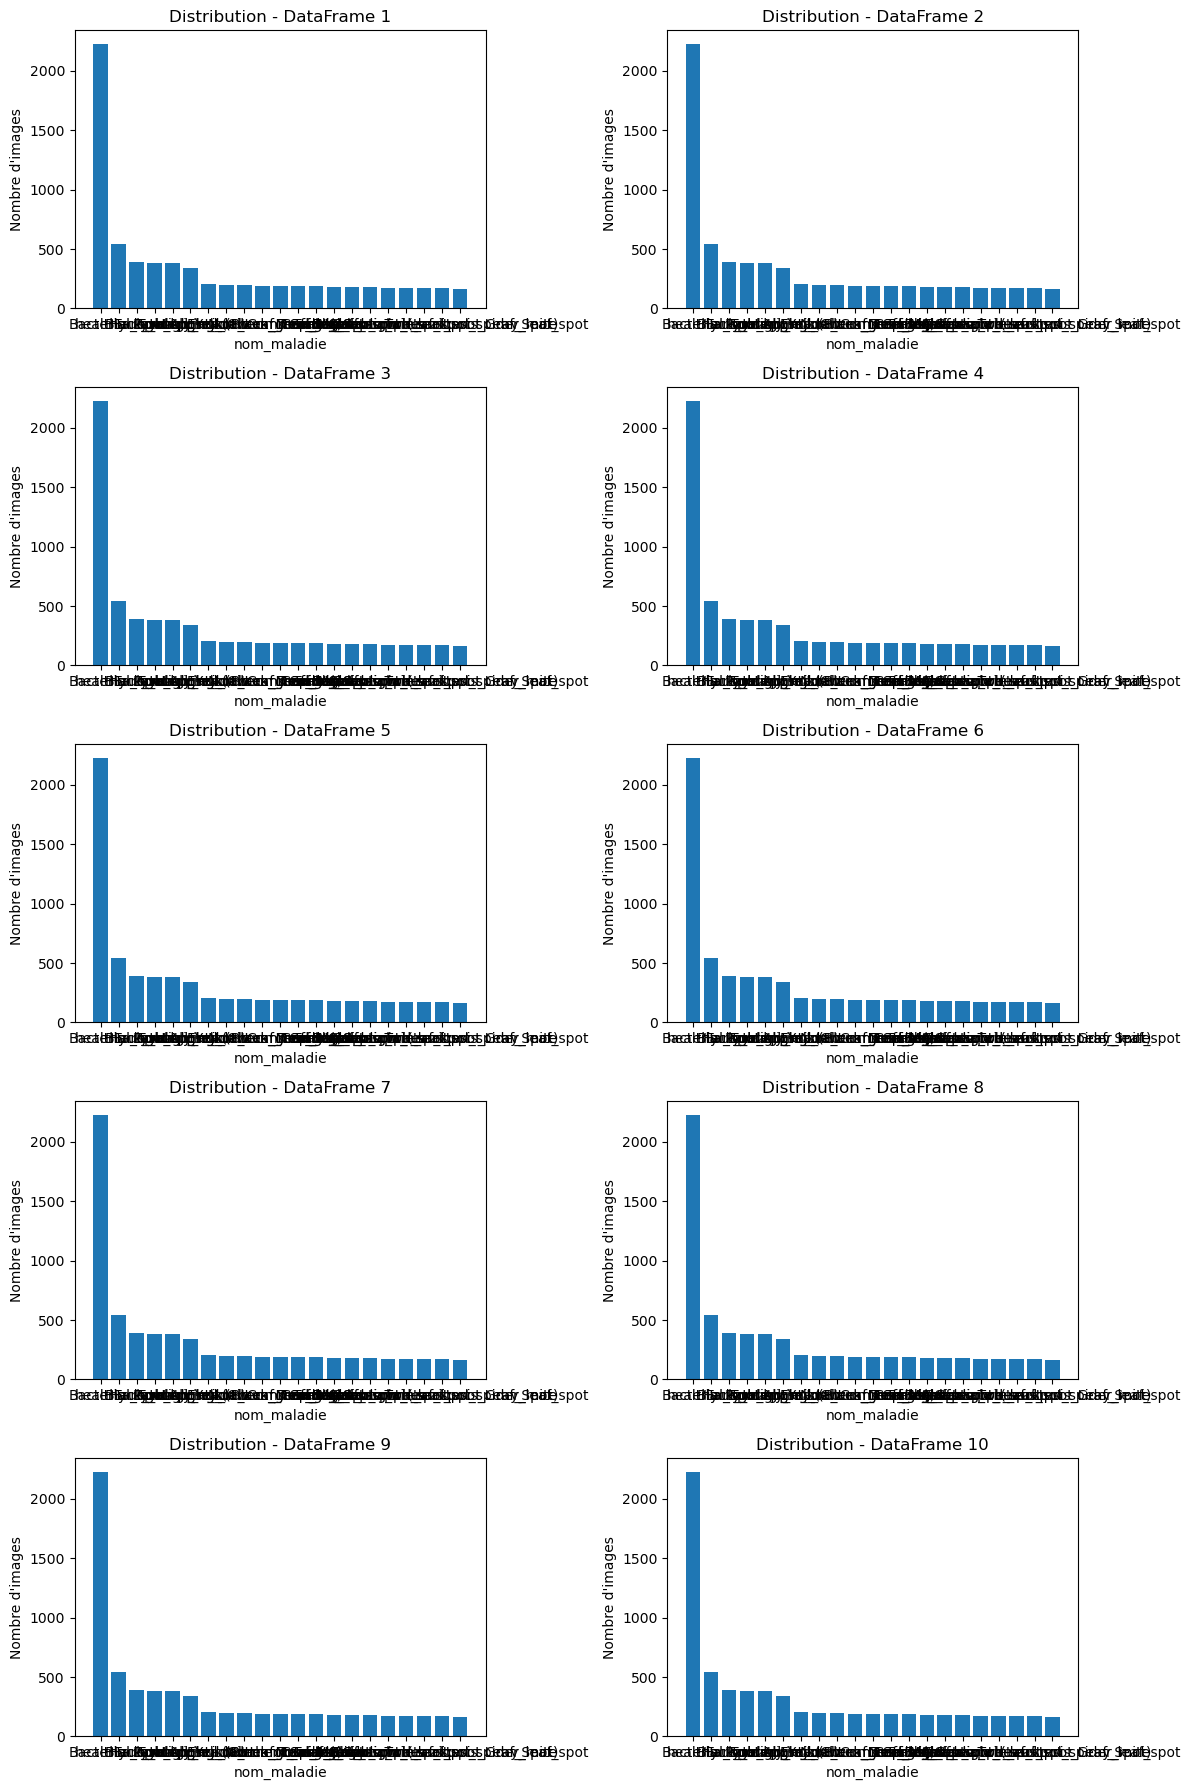

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

X = data.drop(['espece', 'malade', 'nom_maladie'], axis=1)
y = data['nom_maladie']

dfs = []
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.9)
for train_index, _ in sss.split(X, y):
    df = pd.concat([X.iloc[train_index].reset_index(drop=True), y.iloc[train_index].reset_index(drop=True)], axis=1)
    dfs.append(df)

fig, axs = plt.subplots(5, 2, figsize=(12, 18))

for i, df in enumerate(dfs):
    value_counts = df['nom_maladie'].value_counts()
    
    row = i // 2
    col = i % 2
    
    axs[row, col].bar(value_counts.index, value_counts.values)
    axs[row, col].set_title(f"Distribution - DataFrame {i+1}")
    axs[row, col].set_xlabel("nom_maladie")
    axs[row, col].set_ylabel("Nombre d'images")

plt.tight_layout()
plt.show()

### Prétraitement des données 

In [6]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generators = []
validation_generators = []

for i in range(10):
    data_i = dfs[i]  
    
    train_generator = data_generator.flow_from_dataframe(
        dataframe=data_i,
        x_col="img_path",
        y_col="nom_maladie",
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical',
        subset='training'
    )
    train_generators.append(train_generator)
    
    validation_generator = data_generator.flow_from_dataframe(
        dataframe=data_i,
        x_col="img_path",
        y_col="nom_maladie",
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical',
        subset='validation'
    )
    validation_generators.append(validation_generator)

Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 56

### Modèle

In [7]:
# VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freezing

for layer in base_model.layers:
    layer.trainable = False

# Nouvelles couches 

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compilation

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 29s 0us/step


In [8]:
checkpoint_callback = ModelCheckpoint(
    'tf_VGG16_id_nom_maladie.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

# Boucle pour entraîner le modèle pour chaque data_i

for i in range(5):
    train_generator_i = train_generators[i]
    validation_generator_i = validation_generators[i]

    print(f"Entraînement du modèle pour data_{i+1} :")

    history = model.fit(
        train_generator_i,
        steps_per_epoch=train_generator_i.samples // train_generator_i.batch_size,
        epochs=8,
        validation_data=validation_generator_i,
        validation_steps=validation_generator_i.samples // validation_generator_i.batch_size,
        callbacks=[checkpoint_callback]
    )

    print(f"Fin de l'entraînement du modèle pour data_{i+1}.")
    print()

Entraînement du modèle pour data_1 :
Epoch 1/8
87/87 [==============================] - ETA: 0s - loss: 2.4200 - accuracy: 0.3309
Epoch 1: val_accuracy improved from -inf to 0.34226, saving model to tf_VGG16_id_nom_maladie.h5
87/87 [==============================] - 933s 11s/step - loss: 2.4200 - accuracy: 0.3309 - val_loss: 2.2146 - val_accuracy: 0.3423
Epoch 2/8
87/87 [==============================] - ETA: 0s - loss: 1.9575 - accuracy: 0.4126
Epoch 2: val_accuracy improved from 0.34226 to 0.45759, saving model to tf_VGG16_id_nom_maladie.h5
87/87 [==============================] - 932s 11s/step - loss: 1.9575 - accuracy: 0.4126 - val_loss: 1.8050 - val_accuracy: 0.4576
Epoch 3/8
87/87 [==============================] - ETA: 0s - loss: 1.5957 - accuracy: 0.5187
Epoch 3: val_accuracy improved from 0.45759 to 0.54539, saving model to tf_VGG16_id_nom_maladie.h5
87/87 [==============================] - 936s 11s/step - loss: 1.5957 - accuracy: 0.5187 - val_loss: 1.5250 - val_accuracy: 0.54

87/87 [==============================] - 940s 11s/step - loss: 0.5721 - accuracy: 0.8255 - val_loss: 0.5512 - val_accuracy: 0.8333
Epoch 3/8
87/87 [==============================] - ETA: 0s - loss: 0.5531 - accuracy: 0.8302
Epoch 3: val_accuracy did not improve from 0.83333
87/87 [==============================] - 933s 11s/step - loss: 0.5531 - accuracy: 0.8302 - val_loss: 0.5345 - val_accuracy: 0.8311
Epoch 4/8
87/87 [==============================] - ETA: 0s - loss: 0.5389 - accuracy: 0.8356
Epoch 4: val_accuracy did not improve from 0.83333
87/87 [==============================] - 934s 11s/step - loss: 0.5389 - accuracy: 0.8356 - val_loss: 0.5381 - val_accuracy: 0.8274
Epoch 5/8
87/87 [==============================] - ETA: 0s - loss: 0.5287 - accuracy: 0.8403
Epoch 5: val_accuracy improved from 0.83333 to 0.83408, saving model to tf_VGG16_id_nom_maladie.h5
87/87 [==============================] - 938s 11s/step - loss: 0.5287 - accuracy: 0.8403 - val_loss: 0.5291 - val_accuracy: 0.8

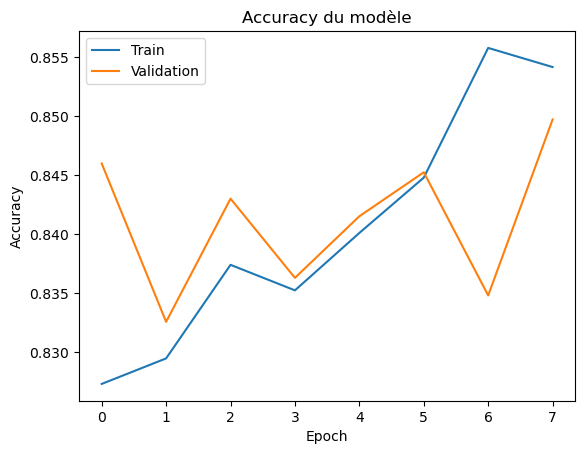

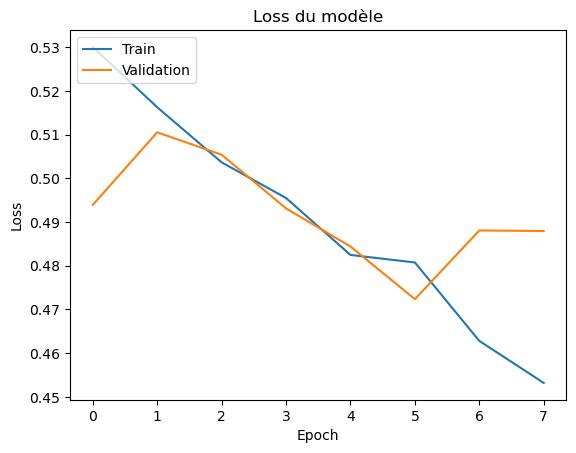

In [9]:
# Visualisation de l'accuracy du train et de la validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy du modèle')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Visualisation de la loss du train et de la validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss du modèle')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Sauvegarde du modèle

In [10]:
# Chargement du modèle

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

model.load_weights('tf_VGG16_id_nom_maladie.h5')

# Compilation 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Sauvegarde du modèle

model.save('model_tf_VGG16_id_nom_maladie_no_bg.h5')